Training neural receiver...
Epoch 1/10
Eb/N0: -10.00 dB, Loss: 1.1390
Eb/N0: -5.00 dB, Loss: 11.6128
Eb/N0: 0.00 dB, Loss: 5.7315
Eb/N0: 5.00 dB, Loss: 4.6752
Eb/N0: 10.00 dB, Loss: 2.8914
Epoch 2/10
Eb/N0: -10.00 dB, Loss: 2.4057
Eb/N0: -5.00 dB, Loss: 2.6115
Eb/N0: 0.00 dB, Loss: 1.1744
Eb/N0: 5.00 dB, Loss: 1.6155
Eb/N0: 10.00 dB, Loss: 1.6505
Epoch 3/10
Eb/N0: -10.00 dB, Loss: 1.3229
Eb/N0: -5.00 dB, Loss: 0.9065
Eb/N0: 0.00 dB, Loss: 1.6841
Eb/N0: 5.00 dB, Loss: 1.7171
Eb/N0: 10.00 dB, Loss: 1.0730
Epoch 4/10
Eb/N0: -10.00 dB, Loss: 1.5312
Eb/N0: -5.00 dB, Loss: 1.8579
Eb/N0: 0.00 dB, Loss: 1.5073
Eb/N0: 5.00 dB, Loss: 0.8622
Eb/N0: 10.00 dB, Loss: 0.8144
Epoch 5/10
Eb/N0: -10.00 dB, Loss: 0.8920
Eb/N0: -5.00 dB, Loss: 1.0093
Eb/N0: 0.00 dB, Loss: 0.9130
Eb/N0: 5.00 dB, Loss: 0.7560
Eb/N0: 10.00 dB, Loss: 0.7112
Epoch 6/10
Eb/N0: -10.00 dB, Loss: 0.8779
Eb/N0: -5.00 dB, Loss: 0.8937
Eb/N0: 0.00 dB, Loss: 0.8592
Eb/N0: 5.00 dB, Loss: 0.7742
Eb/N0: 10.00 dB, Loss: 0.7006
Epoch 7/10


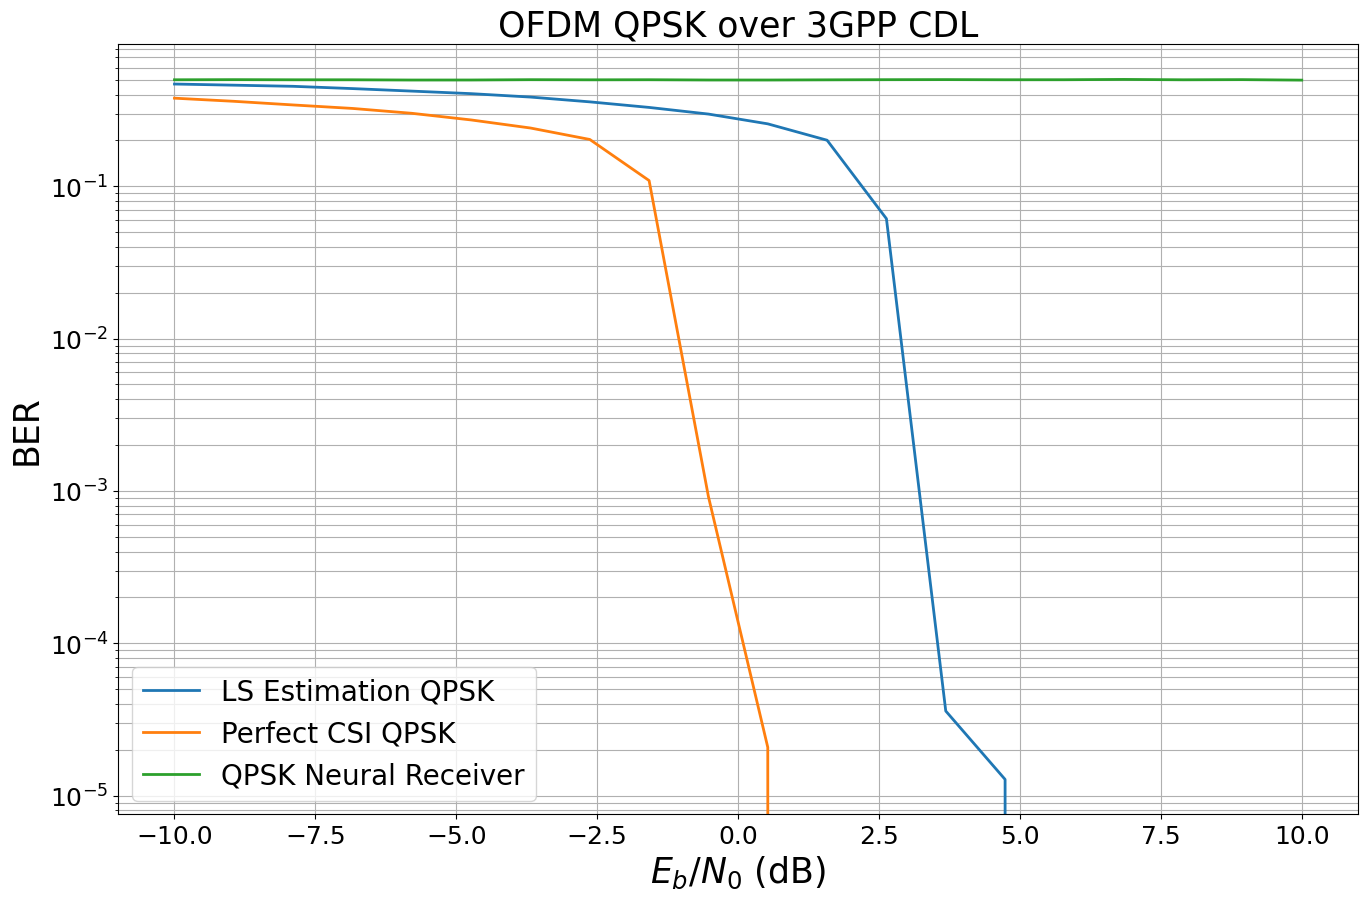

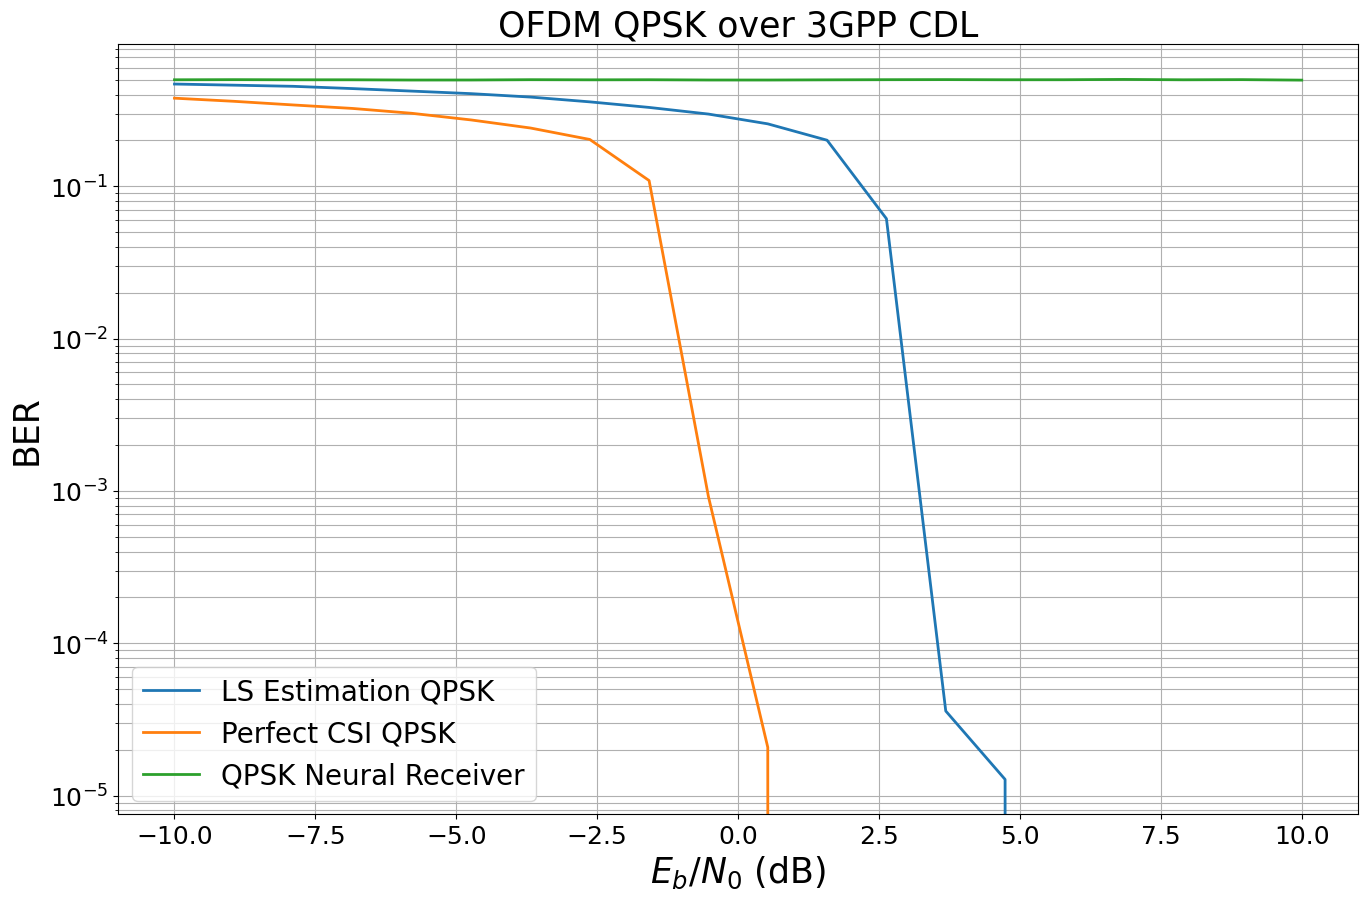

In [7]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try:
    import sionna as sn
except ImportError as e:
    os.system("pip install sionna")
    import sionna as sn

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu
sn.config.seed = 42

class ResidualBlock(Layer):
    def __init__(self):
        super().__init__()
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=128, kernel_size=[3,3], padding='same', activation=None)
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=128, kernel_size=[3,3], padding='same', activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        z = z + inputs
        return z

class NeuralReceiver(Layer):
    def __init__(self):
        super().__init__()
        self._input_conv = Conv2D(filters=128, kernel_size=[3,3], padding='same', activation=None)
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        self._output_conv = Conv2D(filters=NUM_BITS_PER_SYMBOL, kernel_size=[3,3], padding='same', activation=None)

    def call(self, inputs):
        y, no = inputs
        y = tf.squeeze(y, axis=1)
        no = sn.utils.log10(no)
        y = tf.transpose(y, [0, 2, 3, 1])
        no = sn.utils.insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        z = tf.concat([tf.math.real(y), tf.math.imag(y), no], axis=-1)
        z = self._input_conv(z)
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        z = self._output_conv(z)
        z = sn.utils.insert_dims(z, 2, 1)
        return z

class OFDMSystem(Model):
    def __init__(self, perfect_csi):
        super().__init__()
        self.perfect_csi = perfect_csi
        n = int(RESOURCE_GRID.num_data_symbols * NUM_BITS_PER_SYMBOL)
        k = int(n * CODERATE)
        self.k = k
        self.binary_source = sn.utils.BinarySource()
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)
        self.ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)
        self.demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)
        bits = self.binary_source([batch_size, NUM_UT, RESOURCE_GRID.num_streams_per_tx, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)
        y, h_freq = self.channel([x_rg, no])
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

class OFDMSystemNeuralReceiver(Model):
    def __init__(self, training):
        super().__init__()
        self.training = training
        n = int(RESOURCE_GRID.num_data_symbols * NUM_BITS_PER_SYMBOL)
        k = int(n * CODERATE)
        self.k = k
        self.n = n
        self.binary_source = sn.utils.BinarySource()
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=False)
        self.neural_receiver = NeuralReceiver()
        self.rg_demapper = sn.ofdm.ResourceGridDemapper(RESOURCE_GRID, STREAM_MANAGEMENT)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    @tf.function
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)
        if len(no.shape) == 0:
            no = tf.fill([batch_size], no)
        if self.training:
            codewords = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.n])
        else:
            bits = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.k])
            codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)
        y = self.channel([x_rg, no])
        llr = self.neural_receiver([y, no])
        llr = self.rg_demapper(llr)
        llr = tf.reshape(llr, [batch_size, NUM_UT, NUM_UT_ANT, self.n])
        if self.training:
            loss = self.bce(codewords, llr)
            return loss
        else:
            bits_hat = self.decoder(llr)
            return bits, bits_hat

NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 2
NUM_STREAMS_PER_TX = NUM_UT_ANT
RX_TX_ASSOCIATION = np.array([[1]])
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)
NUM_BITS_PER_SYMBOL = 2
CODERATE = 0.5
RESOURCE_GRID = sn.ofdm.ResourceGrid(num_ofdm_symbols=14, fft_size=76, subcarrier_spacing=30e3, num_tx=NUM_UT, num_streams_per_tx=NUM_STREAMS_PER_TX, cyclic_prefix_length=6, pilot_pattern="kronecker", pilot_ofdm_symbol_indices=[2,11])
DELAY_SPREAD = 100e-9
DIRECTION = "uplink"
CDL_MODEL = "C"
SPEED = 10.0
CARRIER_FREQUENCY = 2.6e9
UT_ARRAY = sn.channel.tr38901.Antenna(polarization="single", polarization_type="V", antenna_pattern="38.901", carrier_frequency=CARRIER_FREQUENCY)
BS_ARRAY = sn.channel.tr38901.AntennaArray(num_rows=1, num_cols=int(NUM_BS_ANT/2), polarization="dual", polarization_type="cross", antenna_pattern="38.901", carrier_frequency=CARRIER_FREQUENCY)
CDL = sn.channel.tr38901.CDL(CDL_MODEL, DELAY_SPREAD, CARRIER_FREQUENCY, UT_ARRAY, BS_ARRAY, DIRECTION, min_speed=SPEED)
BATCH_SIZE = 128
EBN0_DB_MIN = -10.0
EBN0_DB_MAX = 10.0

# Train neural receiver
print("Training neural receiver...")
model_neuralrx_train = OFDMSystemNeuralReceiver(training=True)
model_neuralrx_train(BATCH_SIZE, tf.constant(0.0, tf.float32))  # Build model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 10
training_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    epoch_loss = []
    for ebno_db in np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 5):
        with tf.GradientTape() as tape:
            loss = model_neuralrx_train(BATCH_SIZE, tf.constant(ebno_db, tf.float32))
        gradients = tape.gradient(loss, model_neuralrx_train.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_neuralrx_train.trainable_variables))
        print(f"Eb/N0: {ebno_db:.2f} dB, Loss: {loss.numpy():.4f}")
        epoch_loss.append((ebno_db, loss.numpy()))
    training_loss.append(epoch_loss)
# Save training loss
with open('training_loss.txt', 'w') as f:
    f.write("Training Loss\n")
    f.write("Epoch | Eb/N0 (dB) | Loss\n")
    f.write("-" * 30 + "\n")
    for epoch, losses in enumerate(training_loss, 1):
        for ebno_db, loss in losses:
            f.write(f"{epoch} | {ebno_db:.2f} | {loss:.4f}\n")
# Save trained weights
with open('weights-ofdm-neuralrx', 'wb') as f:
    pickle.dump(model_neuralrx_train.get_weights(), f)
print("Training complete. Weights and loss saved.")

ber_plots = sn.utils.PlotBER("OFDM QPSK over 3GPP CDL")
# LS Estimation
model_ls = OFDMSystem(False)
ber_plots.simulate(model_ls, ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20), batch_size=BATCH_SIZE, num_target_block_errors=100, legend="LS Estimation QPSK", soft_estimates=True, max_mc_iter=100, show_fig=False)
# Perfect CSI
model_pcsi = OFDMSystem(True)
ber_plots.simulate(model_pcsi, ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20), batch_size=BATCH_SIZE, num_target_block_errors=100, legend="Perfect CSI QPSK", soft_estimates=True, max_mc_iter=100, show_fig=False)
# Neural Receiver
model_neuralrx = OFDMSystemNeuralReceiver(training=False)
model_neuralrx(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open('weights-ofdm-neuralrx', 'rb') as f:
    weights = pickle.load(f)
    model_neuralrx.set_weights(weights)
ber_plots.simulate(model_neuralrx, ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20), batch_size=BATCH_SIZE, num_target_block_errors=100, legend="QPSK Neural Receiver", soft_estimates=True, max_mc_iter=100, show_fig=True)

# Save BER/BLER results
with open('ber_bler_results.txt', 'w') as f:
    f.write(str(ber_plots))
ber_plots()
plt.savefig("BER_OFDM_QPSK.png", dpi=300, bbox_inches='tight')

In [15]:

import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try:
    import sionna as sn
except ImportError as e:
    os.system("pip install sionna")
    import sionna as sn

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense
sn.config.seed = 42






In [18]:
class ESNReceiver(Layer):
    def __init__(self, reservoir_size=100, spectral_radius=0.9):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.num_rx_ant = 2
        self.fft_size = 76
        self.num_ofdm_symbols = 14
        self.input_size = self.fft_size * 2 * self.num_rx_ant + 1  # 76 * 4 + 1 = 305
        self.output_size = self.fft_size * 2  # 76 * 2 = 152

        # Initialize fixed reservoir weights
        self.W_in = tf.random.uniform([self.input_size, reservoir_size], -0.5, 0.5)
        W_res = tf.random.uniform([reservoir_size, reservoir_size], -0.5, 0.5)
        eigenvalues = tf.linalg.eigvals(W_res)
        max_eigenvalue = tf.reduce_max(tf.abs(eigenvalues))
        self.W_res = W_res * (spectral_radius / max_eigenvalue)
        self.W_out = tf.Variable(tf.random.uniform([reservoir_size, self.output_size], -0.01, 0.01), trainable=True)

    def call(self, inputs, training=False):
        y, no = inputs
        batch_size = tf.shape(y)[0]
        y = tf.squeeze(y, axis=1)  # [128, 2, 14, 76]
        no = sn.utils.log10(no)  # [128]

        # Combine antenna dimension
        y_real = tf.math.real(y)  # [128, 2, 14, 76]
        y_imag = tf.math.imag(y)
        y_combined = tf.concat([y_real, y_imag], axis=1)  # [128, 4, 14, 76]
        y_combined = tf.transpose(y_combined, [0, 2, 3, 1])  # [128, 14, 76, 4]
        y_combined_flat = tf.reshape(y_combined, [batch_size, self.num_ofdm_symbols, -1])  # [128, 14, 304]

        # Add noise as single feature per time step
        no = tf.expand_dims(no, -1)  # [128, 1]
        no_tile = tf.tile(no, [1, self.num_ofdm_symbols])  # [128, 14]
        no_tile = tf.expand_dims(no_tile, -1)  # [128, 14, 1]

        # Concat to form input sequence
        z = tf.concat([y_combined_flat, no_tile], axis=-1)  # [128, 14, 305]

        # Reservoir processing
        state = tf.zeros([batch_size, self.reservoir_size], dtype=tf.float32)
        states = []
        for t in range(self.num_ofdm_symbols):
            u = z[:, t, :]  # [128, 305]
            state = tf.tanh(tf.matmul(u, self.W_in) + tf.matmul(state, self.W_res))
            states.append(state)
        states = tf.stack(states, axis=1)  # [128, 14, reservoir_size]

        # Output computation
        states_flat = tf.reshape(states, [batch_size, -1])  # [128, 14 * reservoir_size]
        output = tf.matmul(states_flat, self.W_out)  # [128, 152]
        output = tf.reshape(output, [batch_size, 1, self.num_ofdm_symbols, self.fft_size, 2])  # [128, 1, 14, 76, 2]

        if training:
            return output, states
        return output

In [19]:
class OFDMSystem(Model):
    def __init__(self, perfect_csi):
        super().__init__()
        self.perfect_csi = perfect_csi
        n = int(RESOURCE_GRID.num_data_symbols * NUM_BITS_PER_SYMBOL)
        k = int(n * CODERATE)
        self.k = k
        self.binary_source = sn.utils.BinarySource()
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)
        self.ls_est = sn.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")
        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)
        self.demapper = sn.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)
        bits = self.binary_source([batch_size, NUM_UT, RESOURCE_GRID.num_streams_per_tx, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)
        y, h_freq = self.channel([x_rg, no])
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

class OFDMSystemESNReceiver(Model):
    def __init__(self, training):
        super().__init__()
        self.training = training
        n = int(RESOURCE_GRID.num_data_symbols * NUM_BITS_PER_SYMBOL)
        k = int(n * CODERATE)
        self.k = k
        self.n = n
        self.binary_source = sn.utils.BinarySource()
        self.encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
        self.mapper = sn.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)
        self.rg_mapper = sn.ofdm.ResourceGridMapper(RESOURCE_GRID)
        self.channel = sn.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=False)
        self.esn_receiver = ESNReceiver()
        self.rg_demapper = sn.ofdm.ResourceGridDemapper(RESOURCE_GRID, STREAM_MANAGEMENT)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    @tf.function
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)
        if len(no.shape) == 0:
            no = tf.fill([batch_size], no)
        if self.training:
            codewords = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.n])
        else:
            bits = self.binary_source([batch_size, NUM_UT, NUM_UT_ANT, self.k])
            codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)
        y = self.channel([x_rg, no])
        if self.training:
            llr, states = self.esn_receiver([y, no], training=True)
            llr = self.rg_demapper(llr)
            llr = tf.reshape(llr, [batch_size, NUM_UT, NUM_UT_ANT, self.n])
            loss = self.bce(codewords, llr)
            return loss, states, codewords
        else:
            llr = self.esn_receiver([y, no], training=False)
            llr = self.rg_demapper(llr)
            llr = tf.reshape(llr, [batch_size, NUM_UT, NUM_UT_ANT, self.n])
            bits_hat = self.decoder(llr)
            return bits, bits_hat

NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 2
NUM_STREAMS_PER_TX = NUM_UT_ANT
RX_TX_ASSOCIATION = np.array([[1]])
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)
NUM_BITS_PER_SYMBOL = 2
CODERATE = 0.5
RESOURCE_GRID = sn.ofdm.ResourceGrid(num_ofdm_symbols=14, fft_size=76, subcarrier_spacing=30e3, num_tx=NUM_UT, num_streams_per_tx=NUM_STREAMS_PER_TX, cyclic_prefix_length=6, pilot_pattern="kronecker", pilot_ofdm_symbol_indices=[2,11])
DELAY_SPREAD = 100e-9
DIRECTION = "uplink"
CDL_MODEL = "C"
SPEED = 10.0
CARRIER_FREQUENCY = 2.6e9
UT_ARRAY = sn.channel.tr38901.Antenna(polarization="single", polarization_type="V", antenna_pattern="38.901", carrier_frequency=CARRIER_FREQUENCY)
BS_ARRAY = sn.channel.tr38901.AntennaArray(num_rows=1, num_cols=int(NUM_BS_ANT/2), polarization="dual", polarization_type="cross", antenna_pattern="38.901", carrier_frequency=CARRIER_FREQUENCY)
CDL = sn.channel.tr38901.CDL(CDL_MODEL, DELAY_SPREAD, CARRIER_FREQUENCY, UT_ARRAY, BS_ARRAY, DIRECTION, min_speed=SPEED)
BATCH_SIZE = 128
EBN0_DB_MIN = -10.0
EBN0_DB_MAX = 10.0

# Train ESN receiver
print("Training ESN receiver...")
model_esn_train = OFDMSystemESNReceiver(training=True)
model_esn_train(BATCH_SIZE, tf.constant(0.0, tf.float32))  # Build model
epochs = 10
training_loss = []
ridge_alpha = 1e-6  # Regularization for ridge regression
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    epoch_loss = []
    states_all = []
    targets_all = []
    for ebno_db in np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 5):
        loss, states, codewords = model_esn_train(BATCH_SIZE, tf.constant(ebno_db, tf.float32))
        states_flat = tf.reshape(states, [BATCH_SIZE, -1])  # [batch_size, num_ofdm_symbols * reservoir_size]
        codewords_flat = tf.reshape(codewords, [BATCH_SIZE, -1])  # [batch_size, n]
        states_all.append(states_flat)
        targets_all.append(codewords_flat)
        print(f"Eb/N0: {ebno_db:.2f} dB, Loss: {loss.numpy():.4f}")
        epoch_loss.append((ebno_db, loss.numpy()))
    # Train output weights using ridge regression
    states_all = tf.concat(states_all, axis=0)  # [num_batches * batch_size, num_ofdm_symbols * reservoir_size]
    targets_all = tf.concat(targets_all, axis=0)  # [num_batches * batch_size, n]
    A = tf.matmul(states_all, states_all, transpose_a=True) + ridge_alpha * tf.eye(states_all.shape[1])
    B = tf.matmul(states_all, targets_all, transpose_a=True)
    W_out = tf.matmul(tf.linalg.inv(A), B)
    model_esn_train.esn_receiver.W_out.assign(W_out)
    training_loss.append(epoch_loss)
# Save training loss
with open('training_loss.txt', 'w') as f:
    f.write("Training Loss (ESN)\n")
    f.write("Epoch | Eb/N0 (dB) | Loss\n")
    f.write("-" * 30 + "\n")
    for epoch, losses in enumerate(training_loss, 1):
        for ebno_db, loss in losses:
            f.write(f"{epoch} | {ebno_db:.2f} | {loss:.4f}\n")
# Save trained weights
with open('weights-ofdm-esn', 'wb') as f:
    pickle.dump(model_esn_train.get_weights(), f)
print("Training complete. Weights and loss saved.")

ber_plots = sn.utils.PlotBER("OFDM QPSK over 3GPP CDL")
# LS Estimation
model_ls = OFDMSystem(False)
ber_plots.simulate(model_ls, ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20), batch_size=BATCH_SIZE, num_target_block_errors=100, legend="LS Estimation QPSK", soft_estimates=True, max_mc_iter=100, show_fig=False)
# Perfect CSI
model_pcsi = OFDMSystem(True)
ber_plots.simulate(model_pcsi, ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20), batch_size=BATCH_SIZE, num_target_block_errors=100, legend="Perfect CSI QPSK", soft_estimates=True, max_mc_iter=100, show_fig=False)
# ESN Receiver
model_esn = OFDMSystemESNReceiver(training=False)
model_esn(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open('weights-ofdm-esn', 'rb') as f:
    weights = pickle.load(f)
    model_esn.set_weights(weights)
ber_plots.simulate(model_esn, ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20), batch_size=BATCH_SIZE, num_target_block_errors=100, legend="QPSK ESN Receiver", soft_estimates=True, max_mc_iter=100, show_fig=True)

# Save BER/BLER results
with open('ber_bler_results.txt', 'w') as f:
    f.write(str(ber_plots))
ber_plots()
plt.savefig("BER_OFDM_QPSK.png", dpi=300, bbox_inches='tight')


Training ESN receiver...


ValueError: in user code:

    File "/tmp/ipykernel_150575/1551205337.py", line 67, in __call__  *
        llr, states = self.esn_receiver([y, no], training=True)
    File "/home/aoschu/anaconda3/envs/OpenNTN/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileawmvzs03.py", line 44, in tf__call
        output = ag__.converted_call(ag__.ld(tf).matmul, (ag__.ld(states_flat), ag__.ld(self).W_out), None, fscope)

    ValueError: Exception encountered when calling layer 'esn_receiver_6' (type ESNReceiver).
    
    in user code:
    
        File "/tmp/ipykernel_150575/4281936019.py", line 52, in call  *
            output = tf.matmul(states_flat, self.W_out)  # [128, 152]
    
        ValueError: Dimensions must be equal, but are 1400 and 100 for '{{node esn_receiver_6/MatMul_28}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](esn_receiver_6/Reshape_1, esn_receiver_6/MatMul_28/ReadVariableOp)' with input shapes: [128,1400], [100,152].
    
    
    Call arguments received by layer 'esn_receiver_6' (type ESNReceiver):
      • inputs=['tf.Tensor(shape=(128, 1, 2, 14, 76), dtype=complex64)', 'tf.Tensor(shape=(128,), dtype=float32)']
      • training=True
